# Sugar Prices

The sugar prices data is taken from [Agricultural Futures Prices (Kaggle, originally Yahoo Finance)](https://www.kaggle.com/datasets/guillemservera/agricultural-futures)

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import statsmodels.api as sm

In [2]:
df_sugar = pd.read_csv('sugar_data.csv')
df_sugar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6097 non-null   object 
 1   open    6097 non-null   float64
 2   high    6097 non-null   float64
 3   low     6097 non-null   float64
 4   close   6097 non-null   float64
 5   volume  6097 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 285.9+ KB


In [3]:
# make date: str -> datetime; when plotting, the date will be used as the x-axis

df_sugar['date'] = pd.to_datetime(df_sugar['date'])  # Convert string to datetime

# Set the date column as the index
df_sugar.set_index('date', inplace=True)

In [4]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, metric, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i][metric]))
    sigmas = np.insert(sigmas, 0, np.full((n), 0))
    return sigmas


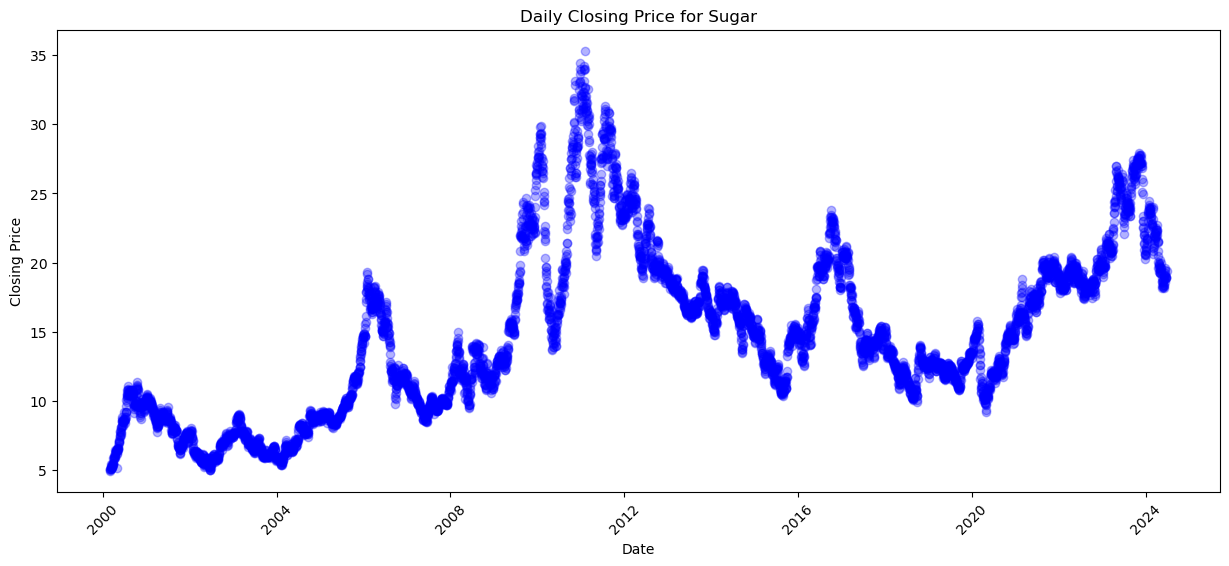

In [5]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, df_sugar['close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Sugar')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [6]:
rolling_sigmas_sugar = volatilities(df_sugar,'close',n=30)

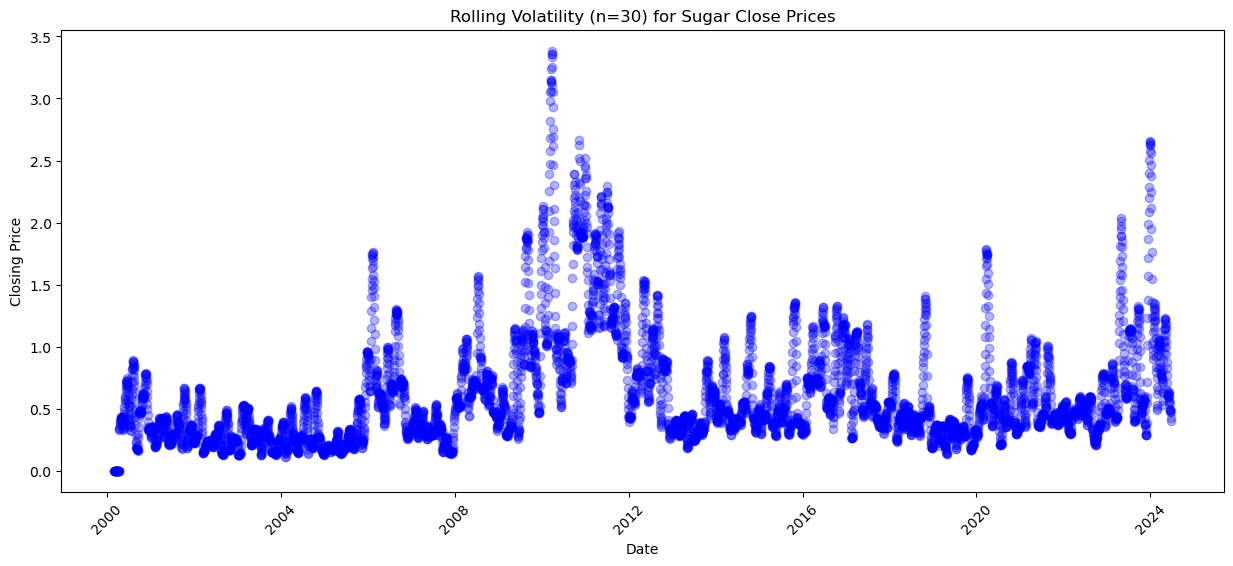

In [7]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, rolling_sigmas_sugar, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

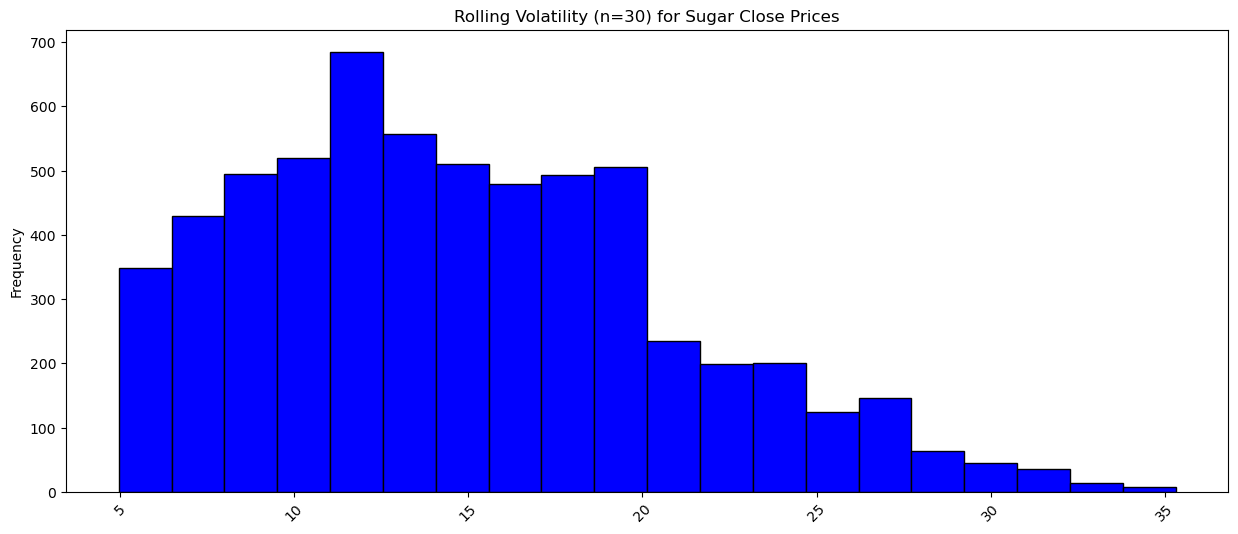

In [8]:
# histogram
plt.figure(figsize=(15, 6))
plt.hist(df_sugar['close'], bins=20, edgecolor='black',color = 'b')
plt.ylabel('Frequency')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

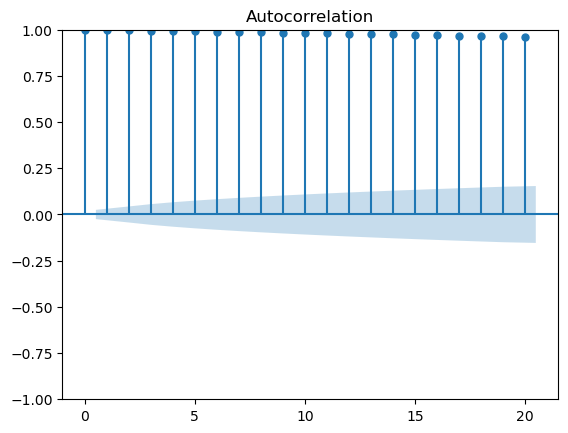

In [9]:
sm.graphics.tsa.plot_acf(df_sugar['close'], lags = 20) # correlation between X and a delayed copy of itself, up to 20 lages
plt.show()

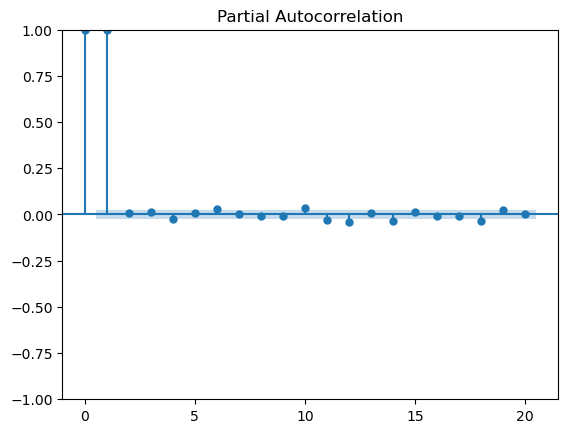

In [10]:
# Partial autocorrelation is a statistical measure in time series analysis that represents the correlation between an observation 
# and its lagged values, while accounting for the influence of all the intervening lags, essentially isolating the direct 
# relationship between two points in time without the effect of other intermediary observations

sm.graphics.tsa.plot_pacf(df_sugar['close'], lags = 20)
plt.show()

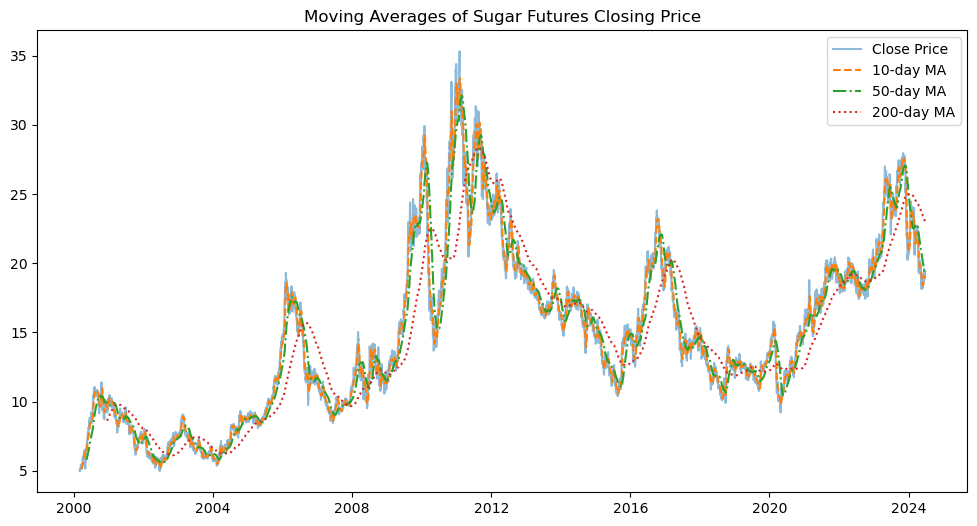

In [11]:
# Moving Averages
df_sugar["MA_10"] = df_sugar["close"].rolling(window=10).mean()
df_sugar["MA_50"] = df_sugar["close"].rolling(window=50).mean()
df_sugar["MA_200"] = df_sugar["close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_sugar["close"], label="Close Price", alpha=0.5)
plt.plot(df_sugar["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_sugar["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_sugar["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Sugar Futures Closing Price")
plt.show()

In [12]:
# for seasonal decomposition
from statsmodels.tsa.seasonal import STL

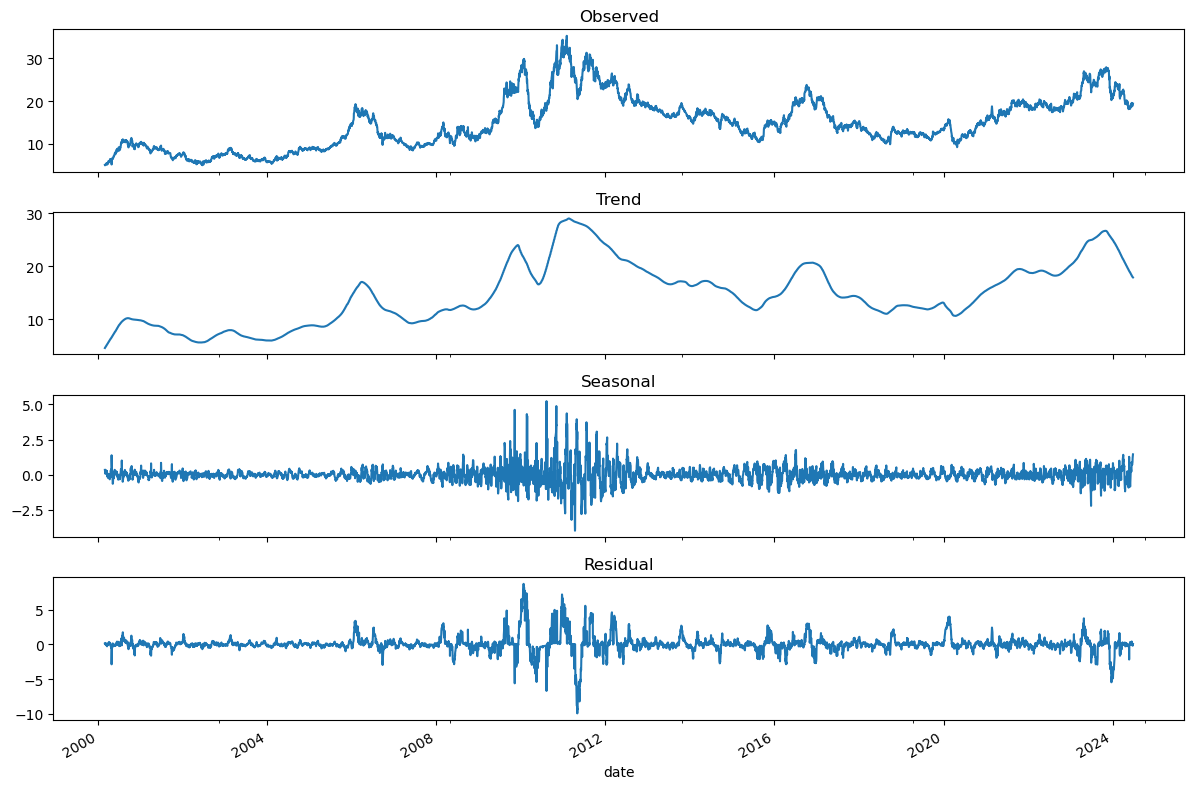

In [13]:
# Seasonal Decomposition (Using STL)
stl = STL(df_sugar["close"], period=60,robust=True)  # 5 day period (since weekends are excluded)
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [15]:
split_index = int(len(df_sugar)*0.8)
df_train = df_sugar[:split_index]['close']
df_test = df_sugar[split_index:]['close']

In [16]:
len(df_train)+len(df_test)==len(df_sugar)

True

In [17]:
# Perform ADF test to check for stationarity
result = adfuller(df_sugar['close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -2.5858266512872627
p-value: 0.09596213580817703


In [18]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usi

                                      SARIMAX Results                                       
Dep. Variable:                                close   No. Observations:                 4877
Model:             SARIMAX(30, 1, 1)x(0, 1, [], 12)   Log Likelihood               -2407.358
Date:                              Wed, 19 Feb 2025   AIC                           4878.715
Time:                                      21:44:34   BIC                           5086.383
Sample:                                           0   HQIC                          4951.601
                                             - 4877                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054     11.733      0.000      1.000     -22.991      23.001
ar.L2          0.00

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


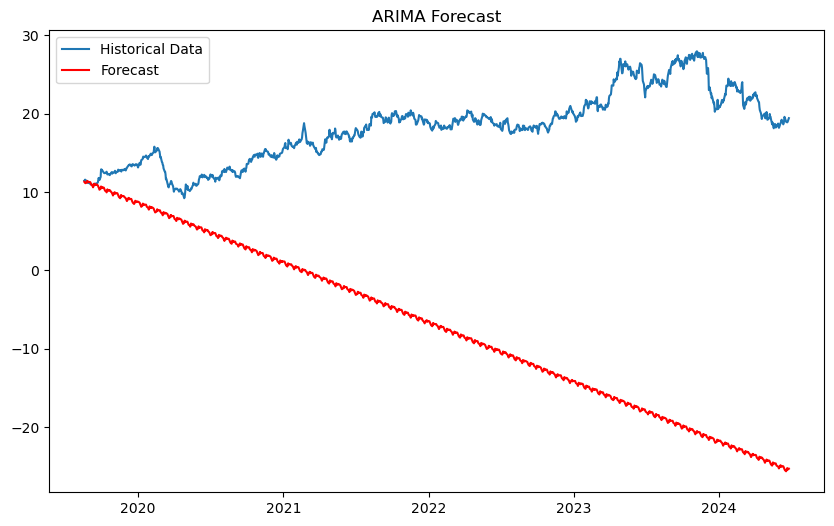

In [19]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = len(df_test)  # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test, label='Historical Data')
plt.plot(df_test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## Compare to corn since corn syrup is widely used in the US while there are tariffs on imported sugar.

In [20]:
corn = yf.Ticker('ZCH25.CBT')
df_corn = corn.history(period = 'max')
df_corn

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-14 00:00:00-05:00,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15 00:00:00-05:00,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16 00:00:00-05:00,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19 00:00:00-05:00,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20 00:00:00-05:00,570.00,570.00,565.50,565.50,1,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-12 00:00:00-05:00,483.75,492.25,481.50,490.25,271391,0.0,0.0
2025-02-13 00:00:00-05:00,489.75,494.25,485.25,493.50,269316,0.0,0.0
2025-02-14 00:00:00-05:00,493.00,499.75,492.50,496.25,195600,0.0,0.0


In [21]:
# Make both indices timezone-naive (some datetime stamps are aware of the time zone)
df_sugar.index = df_sugar.index.tz_localize(None)
df_corn.index = df_corn.index.tz_localize(None)

df_merged = pd.merge(df_sugar, df_corn, left_index=True, right_index=True, how='inner')

In [22]:
df_merged.head()

,open,high,low,close,volume,MA_10,MA_50,MA_200,Open,High,Low,Close,Volume,Dividends,Stock Splits
2022-12-14,19.660000,20.410000,19.590000,20.290001,98681,19.623,19.0520,18.83290,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15,20.280001,20.730000,19.860001,19.980000,105852,19.659,19.0926,18.83960,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16,19.879999,20.290001,19.799999,20.090000,53257,19.720,19.1252,18.84540,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19,20.100000,20.430000,20.030001,20.139999,52544,19.779,19.1544,18.84935,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20,20.150000,20.700001,20.139999,20.580000,74725,19.898,19.1938,18.85590,570.00,570.00,565.50,565.50,1,0.0,0.0


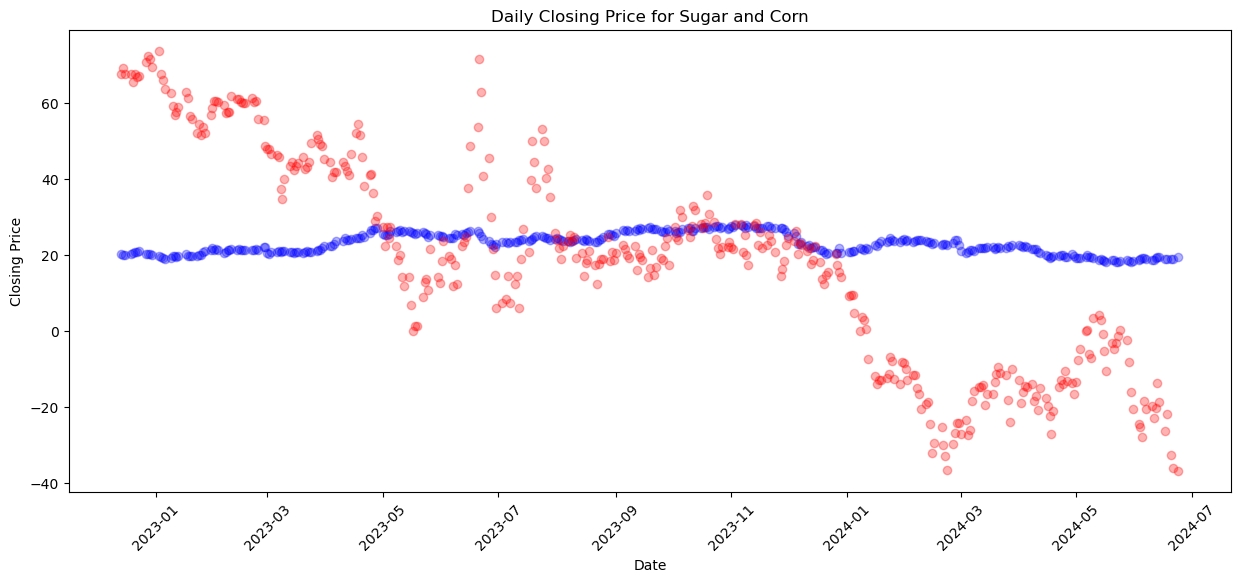

In [23]:
# Plot daily closing price

plt.figure(figsize=(15, 6))
plt.scatter(df_merged.index, df_merged['close'], label='Dataset 1', color='blue',alpha=0.3) # sugar
plt.scatter(df_merged.index, df_merged['Close']-500, label='Dataset 2', color='red',alpha=0.3) # corn but shifted down


plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Sugar and Corn')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

We'll try standardizing each dataset.

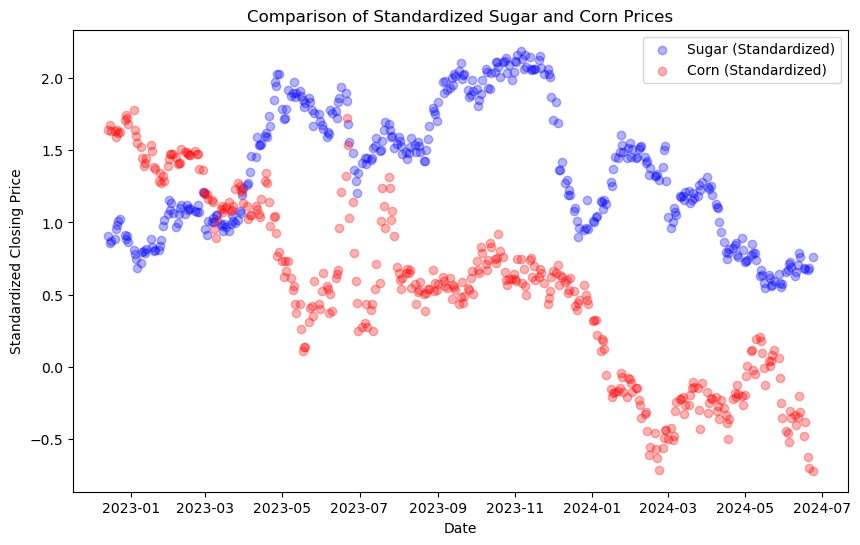

In [24]:
# Standardize each dataset (Z-score normalization)
df_sugar_standard = (df_sugar['close'] - df_sugar['close'].mean()) / df_sugar['close'].std()
df_corn_standard = (df_corn['Close'] - df_corn['Close'].mean()) / df_corn['Close'].std()
df_merged_standard = pd.merge(df_sugar_standard, df_corn_standard, left_index=True, right_index=True, how='inner')

# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged_standard.index, df_merged_standard['close'], label='Sugar (Standardized)', color='blue',alpha=0.3)
plt.scatter(df_merged_standard.index, df_merged_standard['Close'], label='Corn (Standardized)', color='red',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Comparison of Standardized Sugar and Corn Prices')
plt.legend()
plt.show()


In [25]:
print('Covariance Matrix: ', np.cov(df_merged['close'],df_merged['Close']))
print()
print('Correlation:', df_merged['close'].corr(df_merged['Close']))

Covariance Matrix:  [[  7.24513379   8.8328895 ]
 [  8.8328895  750.89049939]]

Correlation: 0.11975434730155342


In [33]:
# let's try to get some kind of rolling covariance/correlation
rolling_cov = df_merged['close'].rolling(window=5).cov(df_merged['Close'])
rolling_cov

2022-12-14         NaN
2022-12-15         NaN
2022-12-16         NaN
2022-12-19         NaN
2022-12-20   -0.280625
                ...   
2024-06-17    1.303501
2024-06-18    1.154501
2024-06-20    1.992753
2024-06-21    0.999253
2024-06-24   -0.749499
Length: 382, dtype: float64

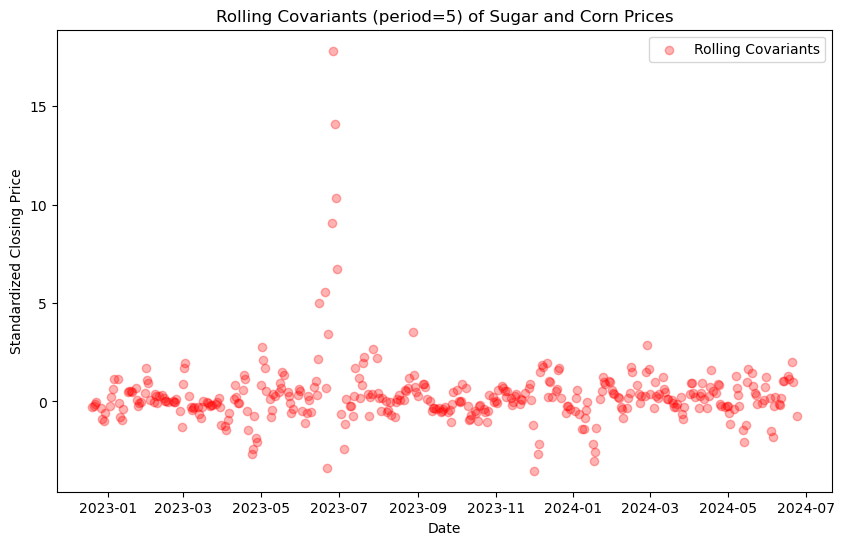

In [ ]:
# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged.index, rolling_cov, label='Rolling Covariants', color='blue',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Rolling Covariants (period=5) of Sugar and Corn Prices')
plt.legend()
plt.show()
